<h1>Preparação para classifier - segmentação e assim</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
from tqdm import tqdm

#%matplotlib widget

## Loading data

In [2]:
HEADER = ['F3', 'Fz', 'F4', 'FC3', 'FCz', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CPz', 'CP4', 'P3', 'Pz', 'P4', 'Oz', 'Photoresistor']
tsv = pd.read_csv("../data/EEG Data.csv", sep="\t", names=HEADER)

In [3]:

"""
Reading the csv generated by the protocol program, we know that:
- The first action was the right hand
- The right hand option is paired with up (both hands)
- The first reponse was HIGH (so ACTION_2)
- Each action was recorded (15 samples per set) * 5 (set count) * 2 (action + imagined) = 150

Also, through value analysis, values before 5300 and after 745900 shouldn't be used, since they are after the experiment end.

Useful numbers to know:
- Expected n of high samples = low samples = 150 * 2 = 300
- Expected n of rests = n high samples + n low samples = 600
- Expected n of pauses = n sets + 1 = 7
"""
data = tsv.to_numpy()[5300:751200, :].T # Should still be useful to use a numpy instead of dict for faster filter processing


## Preprocessing the data

In [4]:
fs = 125
nyq = fs/2

# The signal will be filtered by a filter bank later in the project. The first window i
fl = 2
fh = 45
winlen = 501

# TODO: Calcular um valor teórico para substituir aqui o 501
filt = scp.signal.firwin(winlen, [fl, fh], window = 'hamming', pass_zero = False, fs = fs)


w, h = scp.signal.freqz(filt)

eeg_data = data[:-1]
# A FIR filter, with linear and known group delay was used. The function filtfilt applies the filter forward and backward.
# This way, the group delay cancels out, duplicating the filter order in the process
filtered = scp.signal.filtfilt(filt, [1], eeg_data, axis = 1)

Text(0.5, 0, 'Freq (Hz)')

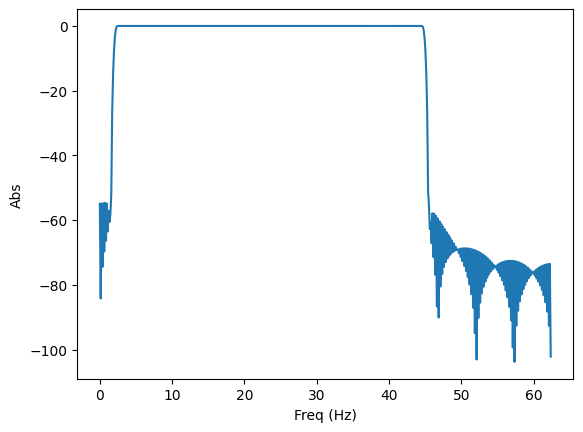

In [8]:
plt.close('all')
plt.figure()
plt.plot(nyq * w/(np.pi), 20 * np.log10(abs(h)))
plt.ylabel("Abs")
plt.xlabel("Freq (Hz)")

### Checking for noise in the frequency domain

In [6]:
from fft import fft

X1 = fft(filtered, axis = 1)

print("X1: ", X1.shape)
print("X1[0]: ", X1[0].shape)

X1:  (16, 1048576)
X1[0]:  (1048576,)


Noise frequency is:  25.197625160217285


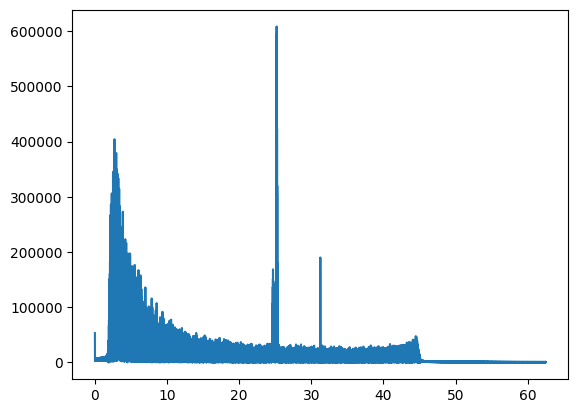

In [10]:
x = np.fft.fftfreq(len(X1[0]), 1/fs)
plt.figure()
plt.plot(x[:int(np.ceil(len(x)/2))], abs(X1[0])[:int(np.ceil(len(X1[0])/2))])

fnoise = x[np.argmax(X1[0])]
print("Noise frequency is: ", fnoise)

## Load segmented data

In [ ]:
segments = np.load('segments.pkl', allow_pickle = True)

In [ ]:
print(segments)

{'left': array([[  2906,   3397],
       [  4909,   5401],
       [  7914,   8409],
       [  9921,  10413],
       [ 11922,  12418],
       [ 13930,  14423],
       [ 14929,  15425],
       [ 16934,  17430],
       [ 18938,  19434],
       [ 20944,  21437],
       [ 23953,  24445],
       [ 25953,  26450],
       [ 27960,  28454],
       [ 28961,  29457],
       [ 31969,  32465],
       [ 35198,  35692],
       [ 37201,  37694],
       [ 39204,  39700],
       [ 40207,  40702],
       [ 43217,  43710],
       [ 45219,  45715],
       [ 47225,  47719],
       [ 49228,  49724],
       [ 51237,  51727],
       [ 52232,  52731],
       [ 54239,  54736],
       [ 56245,  56739],
       [ 58251,  58744],
       [ 61256,  61751],
       [ 63261,  63757],
       [129464, 129963],
       [131472, 131969],
       [134482, 134976],
       [136487, 136980],
       [137484, 137982],
       [140495, 140989],
       [142501, 142994],
       [143497, 143995],
       [146509, 147004],
       [147510, 

In [11]:
def filter_bank(sig):
    bands = []
    f1 = 4
    f2 = 8
    maxf = 40

    # classes = {'rest', 'right', 'left', 'both', 'feet'}

    while f2 <= maxf:
        bands.append([f1, f2])
        f1 += 2
        f2 += 2
    print(bands)

    bandfiltered = []
    # class_bandfiltered = []
    # class_epoch_bandfiltered = []
    
    # for band in tqdm(range(len(bands))):
    #     for class_ in classes:
    #         for epoch in range((np.shape(epoch_sig[class_])[0])):
    #             if band == 9 or band == 10:
    #                 print("removing freq noise")
    #                 filt = scp.signal.firwin(501, [bands[band][0], fnoise - 0.5, fnoise + 0.5, bands[band][1]], pass_zero = False, fs = fs)
    #             else:
    #                 filt = scp.signal.firwin(501, [bands[band][0], bands[band][1]], pass_zero = False, fs = fs)
    #             print(class_)
    #             class_epoch_bandfiltered.append(scp.signal.filtfilt(filt, [1], epoch_sig[class_][epoch], axis = 1))
    #         class_bandfiltered.append(class_epoch_bandfiltered)
    #     bandfiltered.append(class_bandfiltered)
    
    for band in tqdm(range(len(bands))):
        if band == 9 or band == 10:
            print("removing freq noise")
            filt = scp.signal.firwin(501, [bands[band][0], fnoise - 0.5, fnoise + 0.5, bands[band][1]], pass_zero = False, fs = fs)
        else:
            filt = scp.signal.firwin(501, [bands[band][0], bands[band][1]], pass_zero = False, fs = fs)
        bandfiltered.append(scp.signal.filtfilt(filt, [1], sig, axis = 1))

    return bandfiltered



In [12]:
print(filtered.shape)

(16, 745900)


In [ ]:
final = filter_bank(filtered)

[[4, 8], [6, 10], [8, 12], [10, 14], [12, 16], [14, 18], [16, 20], [18, 22], [20, 24], [22, 26], [24, 28], [26, 30], [28, 32], [30, 34], [32, 36], [34, 38], [36, 40]]


 53%|█████▎    | 9/17 [06:17<05:26, 40.78s/it]

removing freq noise


 59%|█████▉    | 10/17 [06:53<04:34, 39.28s/it]

removing freq noise


100%|██████████| 17/17 [11:37<00:00, 41.04s/it]

[array([[-2.73213239e-08, -7.46520865e+01, -1.42402731e+02, ...,
         6.87510379e+01,  3.62669409e+01, -4.79658868e-09],
       [-2.70559102e-08, -7.46861073e+01, -1.42460178e+02, ...,
         9.66159551e+01,  5.09021366e+01, -1.51448718e-08],
       [-1.91405409e-08, -7.55316629e+01, -1.44107158e+02, ...,
         9.49456630e+01,  5.00284295e+01, -3.94457733e-09],
       ...,
       [-1.36151308e-08,  2.04119026e+01,  3.90013166e+01, ...,
        -1.72526841e+02, -9.02739977e+01, -9.21919874e-10],
       [-2.60271695e-08, -6.03294104e+01, -1.14982708e+02, ...,
        -1.69821497e+02, -8.88261224e+01, -1.58372362e-08],
       [-1.41120235e-08, -5.49680786e+01, -1.04737328e+02, ...,
        -1.68005599e+02, -8.78501460e+01,  1.53917901e-09]]), array([[-8.20187651e-09, -8.99015812e+01, -1.64971641e+02, ...,
         8.77485687e+01,  4.79235351e+01, -1.43993439e-09],
       [-8.12222467e-09, -9.11802195e+01, -1.67309554e+02, ...,
         1.15249483e+02,  6.28803873e+01, -4.54650717

In [ ]:
print(len(final))

17


In [ ]:
print(final[0].shape)

# Com o valor 0.1, não dá um número inteiro de samples, adaptado para 0.104

tinit = int(fs * 0.104)
tend = int(fs * 2.104)


left = np.zeros((len(final), len(segments['left'])), dtype=np.ndarray)
right = np.zeros((len(final), len(segments['right'])), dtype=np.ndarray)
both = np.zeros((len(final), len(segments['both'])), dtype=np.ndarray)
feet = np.zeros((len(final), len(segments['feet'])), dtype=np.ndarray)
rest = np.zeros((len(final), len(segments['rest'])), dtype=np.ndarray)

for j in range(len(final)):
	for i in range(left.shape[1]):
		left[j, i] = final[j][:16, segments['left'][i, 0] + tinit : segments['left'][i, 0] + tend]

	for i in range(right.shape[1]):
		right[j, i] = final[j][:16, segments['right'][i, 0] + tinit:segments['right'][i, 0] + tend]

	for i in range(both.shape[1]):
		both[j, i] = final[j][:16, segments['both'][i, 0] + tinit:segments['both'][i, 0] + tend]

	for i in range(feet.shape[1]):
		feet[j, i] = final[j][:16, segments['feet'][i, 0] + tinit:segments['feet'][i, 0] + tend]

	for i in range(rest.shape[1]):
		rest[j, i] = final[j][:16, segments['rest'][i, 0]:segments['rest'][i, 1]]

print(left[0, 100])
print((left).shape)
print((segments['left']).shape)

output = {
	"left": left,
	"right": right,
	"both": both,
	"feet": feet,
	"rest": rest
}

(16, 745900)
[[ 5.6889873   3.73024039  1.34864243 ... 18.8148677  20.02371251
  19.8109125 ]
 [ 7.04610078  4.38858142  1.23542932 ... 18.44046871 19.49867933
  19.20594964]
 [ 5.37022727  3.24769078  0.74868684 ... 19.90631735 20.72973689
  20.04716856]
 ...
 [ 5.6153873   3.04553764  0.13189203 ... 17.66733783 18.77704591
  18.68181159]
 [ 5.98155088  3.7628217   1.1935713  ... 18.90329231 19.70370362
  19.18094258]
 [ 0.79656412 -1.40468448 -3.46546883 ... 21.51553343 22.43105182
  21.75216845]]
(17, 150)
(150, 2)


In [ ]:
print(output['left'].shape)
print(final[0][0].shape)

(17, 150)
(745900,)


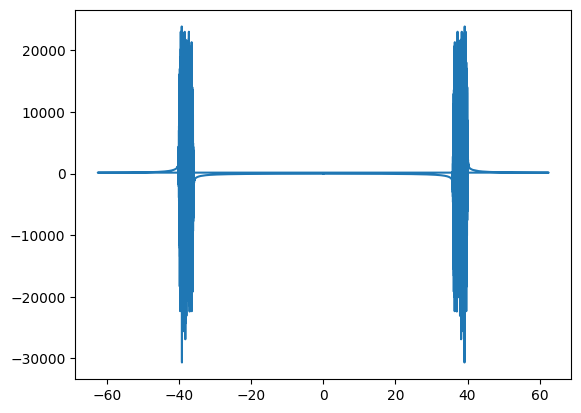

In [ ]:
freqdom = scp.fft.fft(final[16][0])
freqs = scp.fft.fftfreq(len(freqdom), 1/fs)

plt.figure()
plt.plot(freqs, freqdom)


In [ ]:
print(output['left'][0][100])

[[ 5.6889873   3.73024039  1.34864243 ... 18.8148677  20.02371251
  19.8109125 ]
 [ 7.04610078  4.38858142  1.23542932 ... 18.44046871 19.49867933
  19.20594964]
 [ 5.37022727  3.24769078  0.74868684 ... 19.90631735 20.72973689
  20.04716856]
 ...
 [ 5.6153873   3.04553764  0.13189203 ... 17.66733783 18.77704591
  18.68181159]
 [ 5.98155088  3.7628217   1.1935713  ... 18.90329231 19.70370362
  19.18094258]
 [ 0.79656412 -1.40468448 -3.46546883 ... 21.51553343 22.43105182
  21.75216845]]


In [ ]:
import pickle

with open('data_filtered.pkl', 'wb') as f:
	pickle.dump(output, f)